# !pip uninstall keras -y
#!pip uninstall keras-nightly -y
#!pip uninstall keras-Preprocessing -y
#!pip uninstall keras-vis -y
#!pip uninstall tensorflow -y

#!pip3 install tensorflow
#!pip3 install keras
# !pip3 install tensorflow-addons==0.16.1

In [2]:
#Necessary Library
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

import os
from distutils.dir_util import copy_tree, remove_tree

from PIL import Image
from random import randint

#oversampling
#conda install -c conda-forge imbalanced-learn
#https://imbalanced-learn.org/stable/over_sampling.html
from imblearn.over_sampling import SMOTE

#oversampling and under sampling together
from imblearn.combine import SMOTEENN 


from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix

#Extra functionality for TensorFlow
#conda install -c esri tensorflow-addons
import tensorflow_addons as tfa

#https://www.tensorflow.org/tutorials/keras/keras_tuner
#import keras_tuner as kt

from keras.utils.vis_utils import plot_model
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from keras_preprocessing.image import ImageDataGenerator as ImgDataGenerator
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, GlobalAveragePooling2D, LSTM, MaxPooling2D

#In order to display the plot inside the notebook
from plotly.offline import init_notebook_mode
init_notebook_mode(connected = True)

print("Importing Reference done..")

C:\Users\gharb\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
C:\Users\gharb\anaconda3\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.6.0 and strictly below 2.9.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


Importing Reference done..


In [3]:
print("TensorFlow Version:", tf.__version__)
print("Physical Device Available: ", tf.config.list_physical_devices())
print("Logical Device Available: ", tf.config.list_logical_devices())
print("Visible Device Available: ", tf.config.get_visible_devices())

TensorFlow Version: 2.10.0
Physical Device Available:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
Logical Device Available:  [LogicalDevice(name='/device:CPU:0', device_type='CPU')]
Visible Device Available:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [4]:
#Variable declaration
INPUT_DIR = "/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/"
INPUT_DIR = "C:/Users/gharb/A61/SYNTHESE/Dataset/"
BASE_DIR = "./"
BASE_TRAIN_DIR = INPUT_DIR + "train/"
BASE_TEST_DIR  = INPUT_DIR + "test/"

SAVE_DIR = BASE_DIR + "kaggle_median_smoteenn_811_RMSprop_tr_001_100/"

#Check the saved directory and create if not exist
isExist = os.path.exists(SAVE_DIR)
if not isExist:
   os.makedirs(SAVE_DIR)

#after copy in same directory to preprocess
COPY_DIR  = BASE_DIR + "copy_dataset/"

#after preprocessing like filter, blur
PRE_PRO_DIR = BASE_DIR + "pre_pro_dataset/"

#after split
WORKING_DIR = BASE_DIR + "working_dataset/"
TRAIN_DIR = WORKING_DIR + "train/"
TEST_DIR  = WORKING_DIR + "test/"
VAL_DIR   = WORKING_DIR + "val/"

#the classes
CLASSES = [ 'NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']

#Orginal Image
#IMG_SIZE_X = 176
#IMG_SIZE_Y = 208

#Image Resize
IMG_SIZE_X = 128
IMG_SIZE_Y = 128
TARGET_SIZE = (IMG_SIZE_X, IMG_SIZE_Y)

print('variable declaration done')

variable declaration done


In [4]:
#copy the data in single folder
if os.path.exists(COPY_DIR):
    remove_tree(COPY_DIR)    

os.mkdir(COPY_DIR)
copy_tree(BASE_TRAIN_DIR, COPY_DIR)
copy_tree(BASE_TEST_DIR,  COPY_DIR)
print("Copy Directory Contents:", os.listdir(COPY_DIR))

Copy Directory Contents: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


In [ ]:
#Preprocessing defination

import cv2
import argparse

#This function will plot two images side by side
def plot_image(image_1, image_2, title_1="Orignal", title_2="New Image"):
    
    #6/6 inch figure
    width_inch = 8
    height_inch = 5
    plt.figure(figsize=(width_inch, height_inch))
    row = 1
    column = 2
    
    position = 1
    plt.subplot(row, column, position)
    plt.imshow(image_1)
    plt.title(title_1)
    
    position = 2
    plt.subplot(row, column, position)
    plt.imshow(image_2)
    plt.title(title_2)
            
    #save the image
    filter_img_name = title_1 + '.png'
    filter_img_name = SAVE_DIR + filter_img_name.replace(': Original', '')
    print(filter_img_name)m
    plt.savefig(filter_img_name, dpi=100)
    
    #show the image
    plt.show()
    
    
#https://www.kaggle.com/code/natigmamishov/complete-guide-to-image-processing-with-opencv
#funtion for mean filter/blur
def mean_blur(img, image_name, target_folder, kernel=(5, 5)):
    image = cv2.imread(img)
    processed_image = cv2.blur(image, kernel)    
    #cv2.filter2D(image,-1,kernel) = cv2.filter2D(image,-1,kernel)
    writing_path = PRE_PRO_DIR + target_folder + '/' + image_name;
    #print(writing_path)
    cv2.imwrite(writing_path, processed_image)
    #plot_image(image, processed_image)
    
    #return blur
    
#https://www.kaggle.com/code/natigmamishov/complete-guide-to-image-processing-with-opencv   
#funtion for mean filter/blur
def do_median_blur(img, image_name, target_folder, ksize = 3):
    image = cv2.imread(img)
    #processed_image = cv2.medianBlur(image, ksize)
    processed_image = cv2.bilateralFilter(image, 15, 75, 75)
    writing_path = PRE_PRO_DIR + target_folder + '/' + image_name;
    #print(writing_path)
    cv2.imwrite(writing_path, processed_image)
    
    #Images to plot
    img_list = ['mildDem116.jpg', 'moderateDem1.jpg', 'nonDem84.jpg', 'verymildDem56.jpg']
    #print(image_name)
    if image_name in img_list:
        plot_image(image, processed_image, title_1 = target_folder + ": Original", title_2 = target_folder + ": Processed") 
        
#https://www.tutorialspoint.com/python_pillow/python_pillow_adding_filters_to_an_image.htm   
#funtion for DETAIL and EDGE_ENHANCE

#Import required image modules
from PIL import Image, ImageFilter

def detail_and_edge_enhance(img, image_name, target_folder):      
    
    org_image = cv2.imread(img)
    writing_path = PRE_PRO_DIR + target_folder + '/' + image_name;
    #print(writing_path)
    
    #Import all the enhancement filter from pillow
    from PIL.ImageFilter import (
       BLUR, CONTOUR, DETAIL, EDGE_ENHANCE, EDGE_ENHANCE_MORE,
       EMBOSS, FIND_EDGES, SMOOTH, SMOOTH_MORE, SHARPEN
    )
    
    #Create image object
    image = Image.open(img) 
    
    #Applying the blur filter DmmmmmmmmmmETAIL
    #image1 = image.filter(DETAIL)
    
    #Applying the blur filter EDGE_ENHANCE
    #image2 = image.filter(EDGE_ENHANCE)
    
    #Applying the blur filter SHARPEN
    processed_image = image.filter(SHARPEN)
    
    #save the image
    processed_image.save(writing_path)
    
    #Images to plot
    img_list = ['mildDem116.jpg', 'moderateDem1.jpg', 'nonDem84.jpg', 'verymildDem56.jpg']
    #print(image_name)
    if image_name in img_list:
        plot_image(org_image, processed_image, title_1 = target_folder + ": Original", title_2 = target_folder + ": Processed")  


./kaggle_median_smoteenn_811_RMSprop_tr_001_100/NonDemented.png


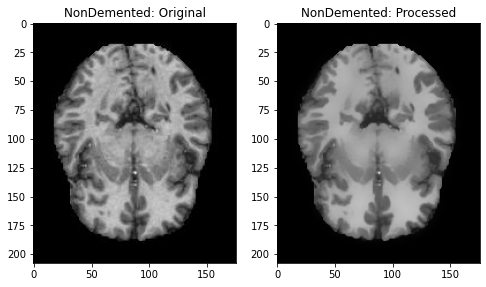

./kaggle_median_smoteenn_811_RMSprop_tr_001_100/VeryMildDemented.png


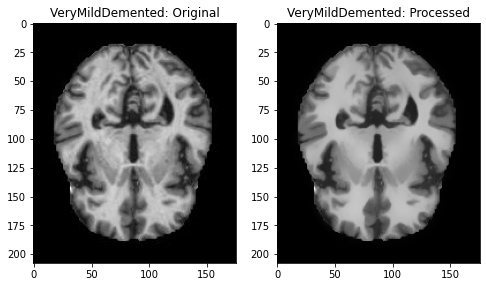

./kaggle_median_smoteenn_811_RMSprop_tr_001_100/MildDemented.png


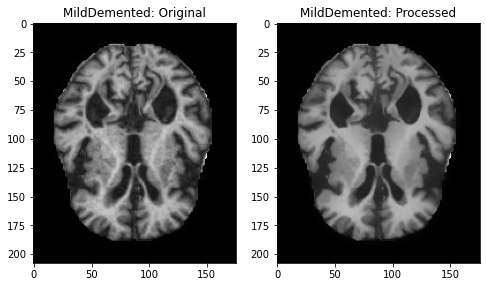

./kaggle_median_smoteenn_811_RMSprop_tr_001_100/ModerateDemented.png


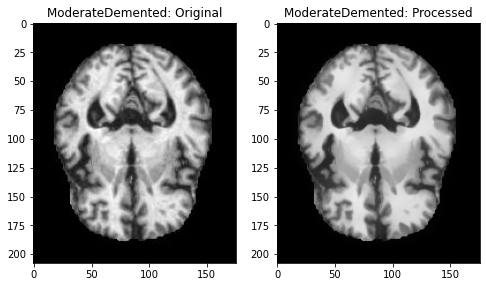

In [31]:
#call for preprocessing
if os.path.exists(PRE_PRO_DIR):
    remove_tree(PRE_PRO_DIR)
os.mkdir(PRE_PRO_DIR)

CLASSES = [ 'NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
for img_class in CLASSES:
    target_folder = img_class
    os.mkdir(PRE_PRO_DIR + target_folder)
    for dirname, _, filenames in os.walk(COPY_DIR + target_folder):
        for filename in filenames:
            do_median_blur(os.path.join(dirname, filename), filename, target_folder)

In [6]:
#Data Augmentation

ZOOM_RANGE = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
#FILL_MODE = "constant"
DATA_FORMAT = "channels_last"
ROTATION_RANGE=0
FILL_MODE = "nearest"

#data generator
#train_ds_datagen = ImgDataGenerator(rotation_range=ROTATION_RANGE, rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM_RANGE, data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)
train_ds_datagen = ImgDataGenerator(rescale = 1./255)
train_ds_generator = train_ds_datagen.flow_from_directory(PRE_PRO_DIR, target_size = (IMG_SIZE_X, IMG_SIZE_Y), batch_size=6500, shuffle=False)

#Retrieving the data from the ImageDataGenerator iterator
TrainImagesGenerated, TrainLabelsGenerated = train_ds_generator.next()
print("Training data retrived.")
print(TrainImagesGenerated.shape, TrainLabelsGenerated.shape)

Found 6400 images belonging to 4 classes.
Training data retrived.
(6400, 128, 128, 3) (6400, 4)


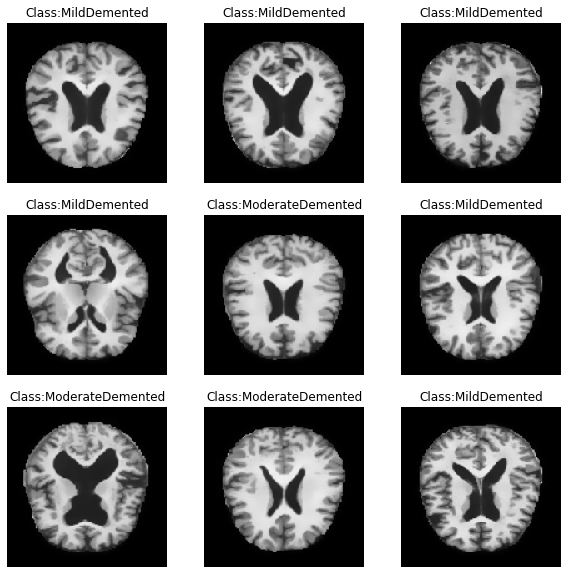

In [7]:
# define funtion to Display random list of Train Images
def show_images(x, y, y_pred=None):
    
    # get image lables
    labels =dict(zip([0,1,2,3], CLASSES))
    
    # get a batch of images
    #x,y = generator.next()
    
    # display a grid of 9 images
    plt.figure(figsize=(10, 10))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            idx = randint(0, 6400)
            plt.imshow(x[idx])
            plt.axis("off")
            plt.title("Class:{}".format(labels[np.argmax(y[idx])]))
                                                     
    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))
            
    plt.savefig(SAVE_DIR + "random_list_of_Train_Images.png", bbox_inches = 'tight')
    
# Display Train Images
show_images(TrainImagesGenerated, TrainLabelsGenerated)


<function matplotlib.pyplot.show(close=None, block=None)>

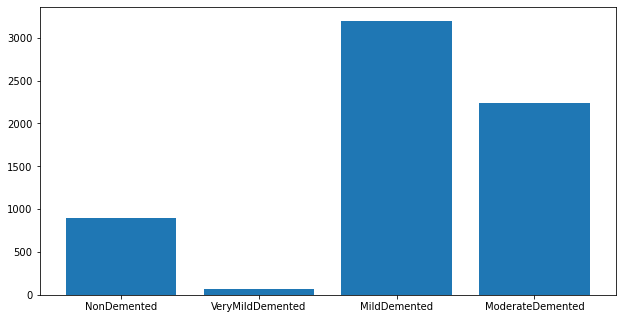

In [8]:
#plot the samples count
fig = plt.figure(figsize=(8, 4))
ax = fig.add_axes([0,0,1,1])
size = [896,64,3200,2240]
ax.bar(CLASSES,size)

#save plot
plt.savefig(SAVE_DIR + "samples_count.png", bbox_inches = 'tight')

#show plot
plt.show

In [9]:
#Performing over-sampling/under-sampling of the data, since the classes are imbalanced

#over_sampling = SMOTE(random_state=42)
over_under_sampling = SMOTEENN()

train_data, train_labels = over_under_sampling.fit_resample(TrainImagesGenerated.reshape(-1, IMG_SIZE_X * IMG_SIZE_Y * 3), TrainLabelsGenerated)
train_data = train_data.reshape(-1, IMG_SIZE_X, IMG_SIZE_Y, 3)

#To skip the over/under sampling upper two lines are commented and below two lines are written
#train_data = TrainImagesGenerated
#train_labels = TrainLabelsGenerated

#Dimensions of the over/under sampled dataset
print("Final dimension of data")
print(train_data.shape, train_labels.shape)

Final dimension of data
(12611, 128, 128, 3) (12611, 4)


In [95]:
c = np.argmax(train_labels,axis=1)
a,b = np.unique(c,return_counts=True)
b 

array([3200, 3200, 3027, 3184], dtype=int64)

<function matplotlib.pyplot.show(close=None, block=None)>

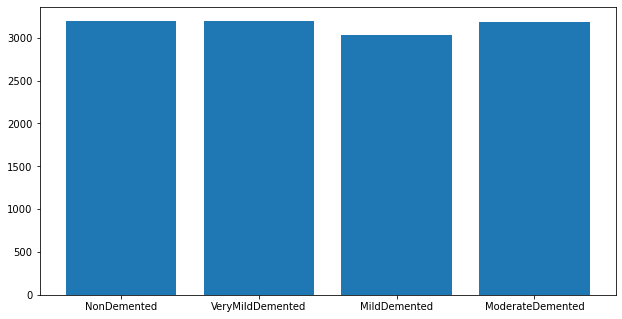

In [98]:
#plot the samples count
fig = plt.figure(figsize=(8, 4))
ax = fig.add_axes([0,0,1,1])
size = [896,64,3200,2240]
size = b
ax.bar(CLASSES,size)

#save plot
plt.savefig(SAVE_DIR + "samples_count.png", bbox_inches = 'tight')

#show plot
plt.show

In [9]:
#Splitting the data into train, test, and validation datasets

train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.1, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.1, random_state=42)

print("Train data shape")
print(train_data.shape, train_labels.shape)

print("Test data shape")
print(test_data.shape, test_labels.shape)

print("Validation data shape")
print(val_data.shape, val_labels.shape)

Train data shape
(10233, 128, 128, 3) (10233, 4)
Test data shape
(1264, 128, 128, 3) (1264, 4)
Validation data shape
(1137, 128, 128, 3) (1137, 4)


In [36]:
pd.DataFrame(train_labels[:,0:4]).sum()


0    3200
1    3200
2    3027
3    3184
dtype: int64

<function matplotlib.pyplot.show(close=None, block=None)>

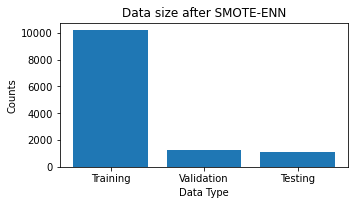

In [10]:
#plot the samples count after SMOTE-ENN

size_train_aftr_smote = train_data.shape[0]
size_test_aftr_smote = test_data.shape[0]
size_val_aftr_smote = val_data.shape[0]

fig = plt.figure(figsize=(4, 2))
ax = fig.add_axes([0,0,1,1])
data_types_tvt = [ 'Training', 'Validation', 'Testing']
size = [size_train_aftr_smote, size_test_aftr_smote, size_val_aftr_smote]
ax.bar(data_types_tvt,size)

plt.title('Data size after SMOTE-ENN')
plt.xlabel('Data Type')
plt.ylabel('Counts')

#save plot
plt.savefig(SAVE_DIR + "samples_count_after_smoteenn.png", bbox_inches = 'tight')

#show plot
plt.show

In [11]:
IMG_SIZE = 150
IMAGE_SIZE = [150, 150]
DIM = (IMG_SIZE, IMG_SIZE)

In [15]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [ ]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("alzheimer_model.h5",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

In [13]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [16]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(*IMAGE_SIZE, 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(4, activation='softmax')
    ])
    
    return model
model = build_model()

In [17]:
model = build_model()
METRICS = [tf.keras.metrics.AUC(name='auc')]
model.compile(
        optimizer='adam',
        loss=tf.losses.CategoricalCrossentropy(),
        metrics=METRICS
    )

In [20]:
history = model.fit(
   train_data,validation_data=val_data,callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler],epochs=2
)

NameError: name 'checkpoint_cb' is not defined